In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import os
from tqdm.notebook import tqdm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
#needed for DNN 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM,GRU,Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
# from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
# from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
# from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.preprocessing.text import Tokenizer
# from sklearn.utils import shuffle

In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/research topic prediction/'

In [ ]:
df = pd.read_csv(PATH + 'data/train_df_extend.csv')
df = df.drop(['ABSTRACT'], axis=1)

In [ ]:
df.head()

,Computer Science,Mathematics,Physics,Statistics,cleaned_text
0,0.0,0.0,1.0,0.0,evergrowing datasets inside observational astr...
1,1.0,0.0,0.0,0.0,propose framework consider optimal tmatchings ...
2,0.0,0.0,1.0,0.0,nanostructures open shell transition metal mol...
3,0.0,0.0,1.0,0.0,star selfgravitating fluid inside pressure buo...
4,1.0,0.0,0.0,0.0,deep neural perception control network likely ...


In [ ]:
# set aside 20% of train and test data for evaluation
df.cleaned_text=df.cleaned_text.astype(str)

X = df.cleaned_text
Y = df.iloc[:,0:4]

def dataset_split(inputs, tags):

    X,X_test,y,y_test = train_test_split(inputs,tags,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
    X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
    print("\nDataset Distribution:\n")
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",len(inputs),
        "\n\tTraining\t\t",len(X_train),
        "\n\tTest\t\t\t",len(X_test),
        "\n\tValidation\t\t",len(X_valid))
  
    return X_train,X_valid,X_test,y_train,y_valid,y_test

X_train,X_valid,X_test,y_train,y_valid,y_test = dataset_split(X,Y)


Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 21338 
	Training		 17283 
	Test			 2134 
	Validation		 1921


In [ ]:

import nltk
from tqdm import tqdm
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Train Data Tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_length = 200
vocab_size = 73971  

tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>",filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',lower=True)
tokenizer.fit_on_texts(X_train.values)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Taining Data padding
train_sequences = tokenizer.texts_to_sequences(X_train.values)
train_padded = pad_sequences(train_sequences,padding='post', maxlen=max_length)

# Validation Data padding
validation_sequences = tokenizer.texts_to_sequences(X_valid.values)
validation_padded = pad_sequences(validation_sequences,padding='post', maxlen=max_length)

# testing data padding
test_sequences = tokenizer.texts_to_sequences(X_test.values)
test_padded = pad_sequences(test_sequences,padding='post',maxlen=max_length)

test_padded[0]

Found 73971 unique tokens.


array([   29,   204,     3,    49,  5848,   323,    36,   405,  6337,
         962,   162,     4,   351, 10199,   275,  7065,    19,  1610,
         421,   567,  2764,    21,    42,  3195,    17,    20,  3262,
           4,  1741,    62,   327,  1186,  1204,   312,   119,  1097,
         172,     7,  2467,    27,    35,     5,     2,   122,    47,
           7,     2,    16,  1282,   118,    46,   312,   172,   139,
         235,   824,   171,   290,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [ ]:
####
embedding_vector = {}
f = open('/content/drive/MyDrive/Colab Notebooks/CyberBullying Detection/glove file/glove.6B.300d.txt',encoding="utf8")
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef
embedding_matrix = np.zeros((vocab_size,300))
for word,i in tqdm(word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

400000it [00:28, 13979.61it/s]
100%|██████████| 73971/73971 [00:00<00:00, 611527.93it/s]


In [ ]:
def padded_infos(original,encoded,padded):
  print("\n\t\t\t Encoded Sequences ","\n")  
  print(original,"\n",encoded) 
  print("\n\t\t\t Paded Sequences \n",original,"\n",padded)

padded_infos(X_train[2],train_sequences[2],train_padded[2])


			 Encoded Sequences  

nanostructures open shell transition metal molecular constituent host often strong electronic correlation highly sensitive atomistic material detail tutorial review discus method development application theoretical approach consider realistic description electronic magnetic property nanostructures correlate electron first implementation flexible interface density functional theory variant dynamical mean field theory dmft highly suitable consider simulation complex correlate structure explain illustrated dmft side interface largely base recent development quantum monte carlo exact diagonalization technique allow consider efficient description general four fermion coulomb interaction reduce symmetry spinorbit couple explain example cr 001 surface magnetic adatoms molecular system show interplay hubbard u hunds j determines charge spin fluctuation interaction drive different sort correlation effect inside nanosystems nonlocal interaction correlation present parti

In [ ]:
#confusion matrix
def conf_matrix(y_pred):
  # preds = np.where(y_pred < 0.5, 0, 1)
  cm = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1)) 
# Transform to df for easier plotting
  
  cm_df = pd.DataFrame(cm,
                       index = ['Computer Science', 'Mathematics', 'Physics', 'Statistics'], 
                       columns = ['Computer Science', 'Mathematics', 'Physics', 'Statistics'])
  sns.set(font_scale=2) 
  plt.figure(figsize=(10,8))
  sns.heatmap(cm_df, annot=True,cmap="coolwarm", fmt='g')
  plt.ylabel('True label',fontsize=20)
  plt.xlabel('Predicted label',fontsize=20)
  plt.xticks( rotation=90, weight = 'bold')
  plt.yticks( rotation=0, weight = 'bold')
  plt.show()
  plt.close()

In [ ]:
accuracy_threshold = 0.999
from tensorflow import keras
keras.backend.clear_session()
#callback function for early stopping
class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('binary_accuracy') > ACCURACY_THRESHOLD):
      if(logs.get('binary_accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()


In [ ]:
embedding_dim=300
num_category = 4
opt=RMSprop(0.001)


In [ ]:
def Bidirectional_classifier_model(model_name,file_name,GRU_unit, epochs, batch, p_optimizer:str = 'adam' , 
                                   p_loss:str = 'binary_crossentropy', p_metrics:list = ['binary_accuracy']):
    """
    Build a Bidirectional Models for classification
    """
    filepath = 'models/'+file_name
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.5, patience=2, 
                                    verbose=1, mode='auto', 
                                    min_delta=0.001, cooldown=1, min_lr=0.00001)
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_binary_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='auto')
    
    callback_list = [acc_callback, checkpoint ]
    
    print('----------------------------- sequential_classifier_model -----------------------------')
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(73971, embedding_dim, input_length=train_padded.shape[1],weights=[embedding_matrix],trainable =False),
        tf.keras.layers.SpatialDropout1D(0.2),
        tf.keras.layers.Bidirectional(model_name(GRU_unit,return_sequences=True)),
        tf.keras.layers.Dense(28, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_category, activation='sigmoid')
])
    model.compile(optimizer=p_optimizer, loss = p_loss, metrics = p_metrics)
    model.summary()
    model_history = model.fit(train_padded, y_train, 
                    epochs=epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, y_valid), 
                    verbose=1,
                    callbacks = callback_list)
    return model,model_history

In [ ]:
# Bidirection GRU 
BiGRU_model, BiGRU_history = Bidirectional_classifier_model(model_name = GRU,
                                                            file_name = 'BiGRU.h5',
                                                            GRU_unit = 128,
                                                            epochs = 100,
                                                            batch = 128)

----------------------------- sequential_classifier_model -----------------------------
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 300)          22191300  
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 200, 300)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 200, 256)         330240    
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 200, 28)           7196      
                                                                 
 dropout_4 (Dropout)         (None, 200, 28)           0         
                                

67/67 [==============================] - 2s 13ms/step - loss: 0.4676 - binary_accuracy: 0.9010
loss 0.4675557613372803
Accuracy 0.9010074734687805
Precision 0.8907885917472171
Recall 0.9095724415410978
f1 score 0.9000825271280118


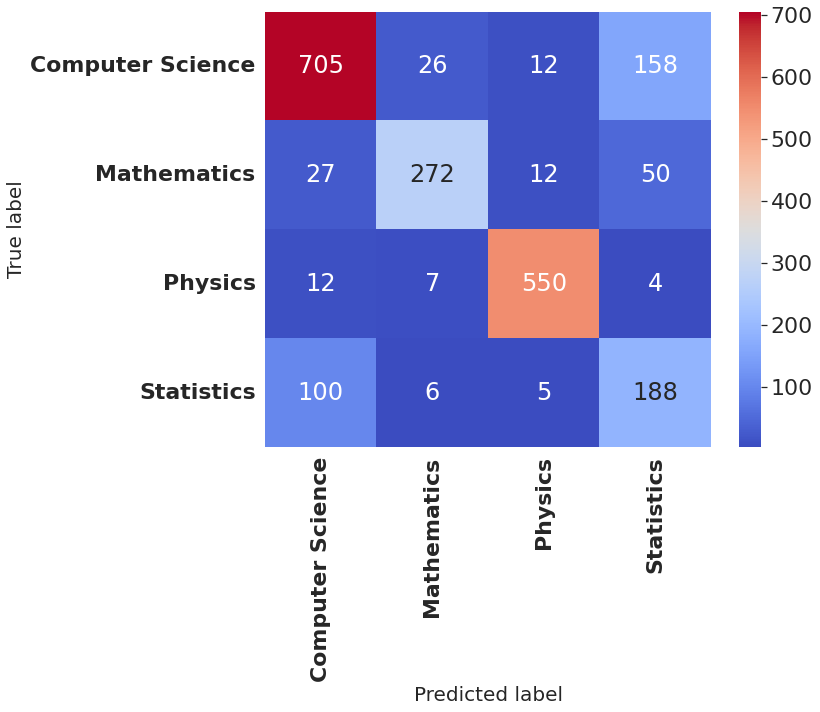

In [ ]:
#make predictions

model = load_model("models/BiGRU.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
testing_label_seq_numpy = y_test.to_numpy()
evaluation = model.evaluate(test_padded,y_test)
weighted_averaged_recall = average_precision_score(testing_label_seq_numpy, predictions, average='micro')
weighted_averaged_precision = average_precision_score(testing_label_seq_numpy, predictions,  average='macro')
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(weighted_averaged_precision))
print('Recall {}'.format(weighted_averaged_recall))
print('f1 score {}'.format(2*((weighted_averaged_recall*weighted_averaged_precision)/(weighted_averaged_recall+weighted_averaged_precision))))

conf_matrix(predictions)

In [ ]:
#Report generation

def report_generate(pred,classifier):
  # Computer Science	Mathematics	Physics	Statistics
  report = pd.DataFrame(classification_report(y_true = y_test.values.argmax(axis=1), y_pred =np.argmax(pred, axis=1), output_dict=True)).transpose()
  report = report.rename(index={'0': 'Computer Science','1':'Mathematics','2':'Physics', '3': 'Statistics'})
  report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
  report=report.drop(["support"],axis=1)

  columns = ['precision','recall','f1-score']
  report.columns = columns
  plt = report.plot(kind='bar',figsize=(12,6))
  plt.set_title('Multi-class Classification Report for '+str(classifier)+' .', fontsize=20)
  plt.tick_params(axis='x',rotation=30,labelsize=25)
  plt.tick_params(axis='y',rotation=0,labelsize=25)
  plt.legend(['precision', 'recall', 'f1-score'], loc=2,bbox_to_anchor = (1,1), prop={'size': 20})
  plt.grid('white')
  return plt,report

,precision,recall,f1-score
Computer Science,83.53,78.25,80.80
Mathematics,87.46,75.35,80.95
Physics,94.99,95.99,95.49
Statistics,47.00,62.88,53.79
accuracy,80.37,80.37,80.37
macro avg,78.25,78.11,77.76
weighted avg,82.15,80.37,80.99


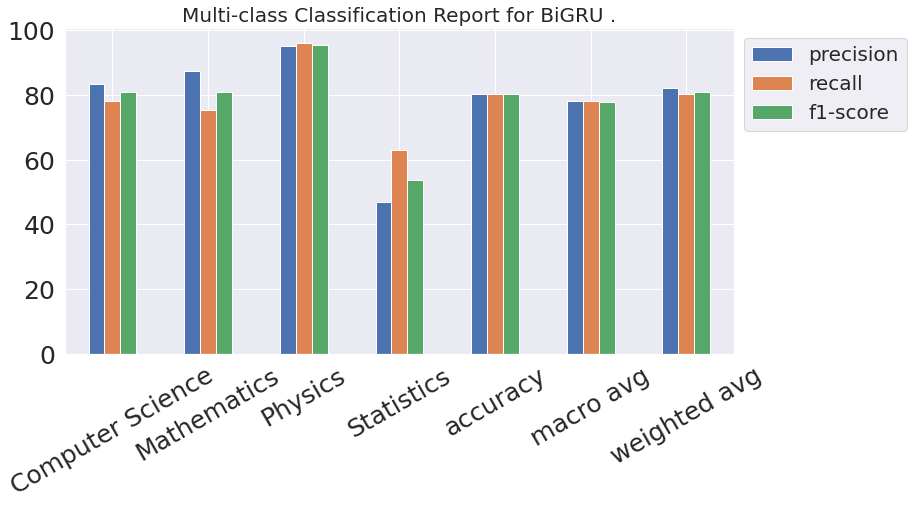

In [ ]:
GRUreport=report_generate(predictions,"BiGRU")
GRUreport[1]

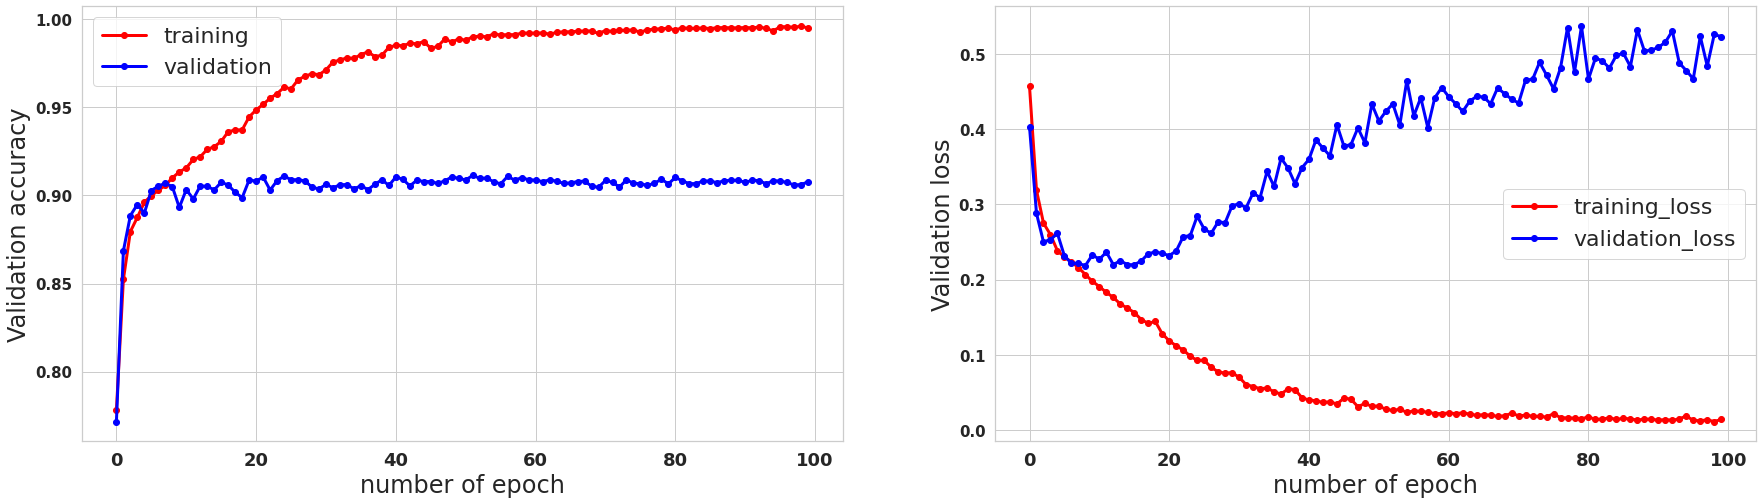

In [ ]:
def model_evaluate(history):
  sns.set_style("whitegrid")
  H = history.history
  fig = plt.figure(figsize = (30, 8))
  plt.subplot(121)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation accuracy")
  plt.plot(H['binary_accuracy'], label = 'training', marker='o', color='red', linewidth=3 )
  plt.plot(H['val_binary_accuracy'], label = 'validation', marker='o', color='blue', linewidth=3 )
  plt.xticks( rotation=0, weight = 'bold', )
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend()

  plt.subplot(122)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation loss")
  plt.plot(H['loss'], label = 'training_loss', marker='o', color='red', linewidth=3 )
  plt.plot(H['val_loss'], label = 'validation_loss', marker='o', color='blue', linewidth=3 )
  plt.xticks( rotation=0, weight = 'bold', )
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend()
    
model_evaluate(BiGRU_history)

In [ ]:
BiLSTM_model, BiLSTM_history = Bidirectional_classifier_model(model_name = LSTM,
                                                            file_name = 'BiLSTM.h5',
                                                            GRU_unit = 128,
                                                            epochs = 100,
                                                            batch = 256)

----------------------------- sequential_classifier_model -----------------------------
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 300)          22191300  
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 200, 300)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_3 (Bidirectio  (None, 200, 256)         439296    
 nal)                                                            
                                                                 
 dense_15 (Dense)            (None, 200, 28)           7196      
                                                                 
 dropout_12 (Dropout)        (None, 200, 28)           0         
                                

67/67 [==============================] - 2s 15ms/step - loss: 0.2386 - binary_accuracy: 0.9038
loss 0.23859228193759918
Accuracy 0.9038191437721252
Precision 0.8981640058924613
Recall 0.9164320739539051
f1 score 0.9072060849381582


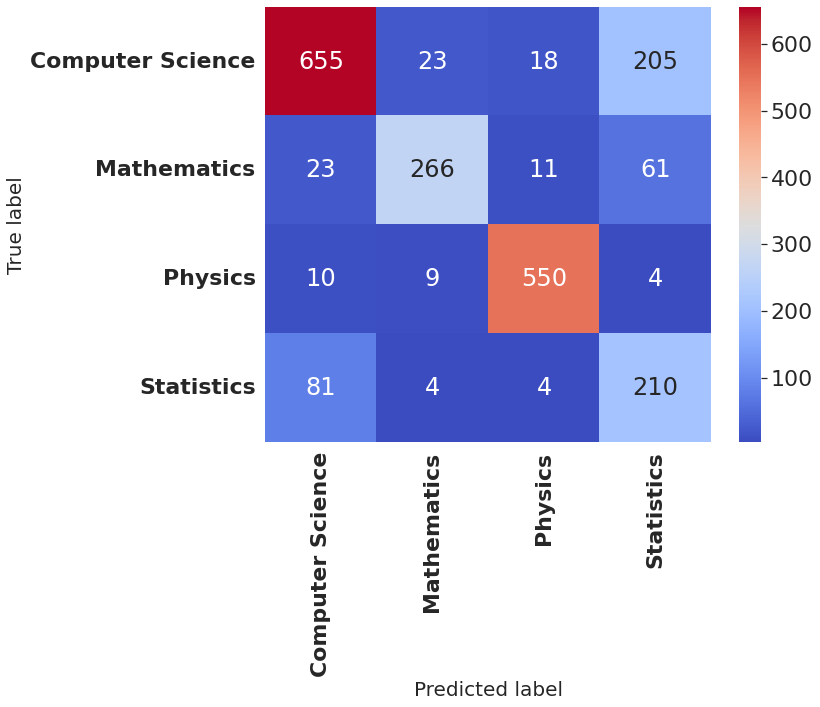

In [ ]:
#make predictions


model = load_model("models/BiLSTM.h5")
predictions = model.predict(test_padded)
testing_label_seq_numpy = y_test.to_numpy()
evaluation = model.evaluate(test_padded,y_test)
weighted_averaged_recall = average_precision_score(testing_label_seq_numpy, predictions, average='micro')
weighted_averaged_precision = average_precision_score(testing_label_seq_numpy, predictions,  average='macro')
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(weighted_averaged_precision))
print('Recall {}'.format(weighted_averaged_recall))
print('f1 score {}'.format(2*((weighted_averaged_recall*weighted_averaged_precision)/(weighted_averaged_recall+weighted_averaged_precision))))

conf_matrix(predictions)

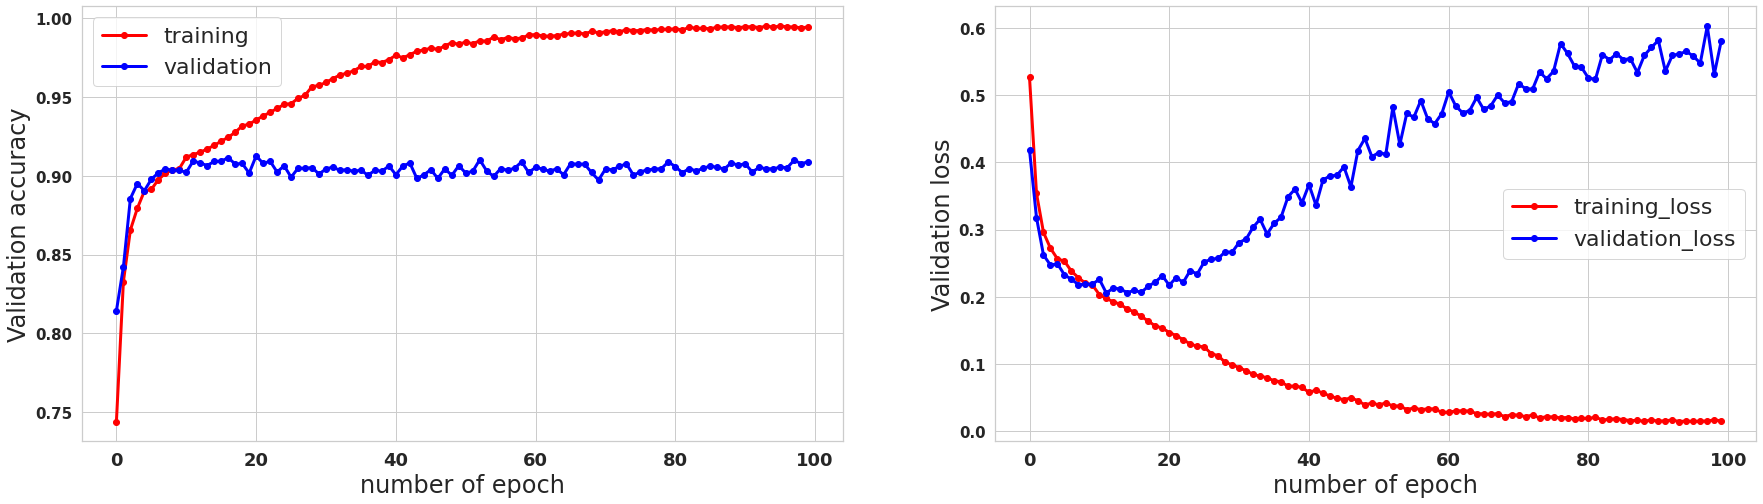

In [ ]:
model_evaluate(BiLSTM_history)

In [ ]:
def directional_classifier_model(model_name,file_name,GRU_unit, epochs, batch, p_optimizer:str = 'adam' , 
                                   p_loss:str = 'binary_crossentropy', p_metrics:list = ['binary_accuracy']):
    """
    Build a directional Models for classification
    """
    filepath = 'models/'+file_name
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.5, patience=2, 
                                    verbose=1, mode='auto', 
                                    min_delta=0.001, cooldown=1, min_lr=0.00001)
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_binary_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='auto')
    
    callback_list = [acc_callback, checkpoint]
    
    print('----------------------------- sequential_classifier_model -----------------------------')
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(73971, embedding_dim, input_length=train_padded.shape[1],weights=[embedding_matrix],trainable =False),
        tf.keras.layers.SpatialDropout1D(0.2),
        model_name(GRU_unit,return_sequences=True),
#         model_name(128, dropout = 0.2),
        tf.keras.layers.Dense(28, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_category, activation='sigmoid')
])
    model.compile(optimizer=p_optimizer, loss = p_loss, metrics = p_metrics)
    model.summary()
    model_history = model.fit(train_padded, y_train, 
                    epochs=epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, y_valid), 
                    verbose=1,
                    callbacks = callback_list)
    return model,model_history

In [ ]:
LSTM_model, LSTM_history =directional_classifier_model(model_name = LSTM,
                                                            file_name = 'LSTM.h5',
                                                            GRU_unit = 128,
                                                            epochs = 100,
                                                            batch = 256)


----------------------------- sequential_classifier_model -----------------------------
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 300)          22191300  
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 200, 300)         0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 200, 128)          219648    
                                                                 
 dense_20 (Dense)            (None, 200, 28)           3612      
                                                                 
 dropout_16 (Dropout)        (None, 200, 28)           0         
                                                                 
 dense_21 (Dense)            (No

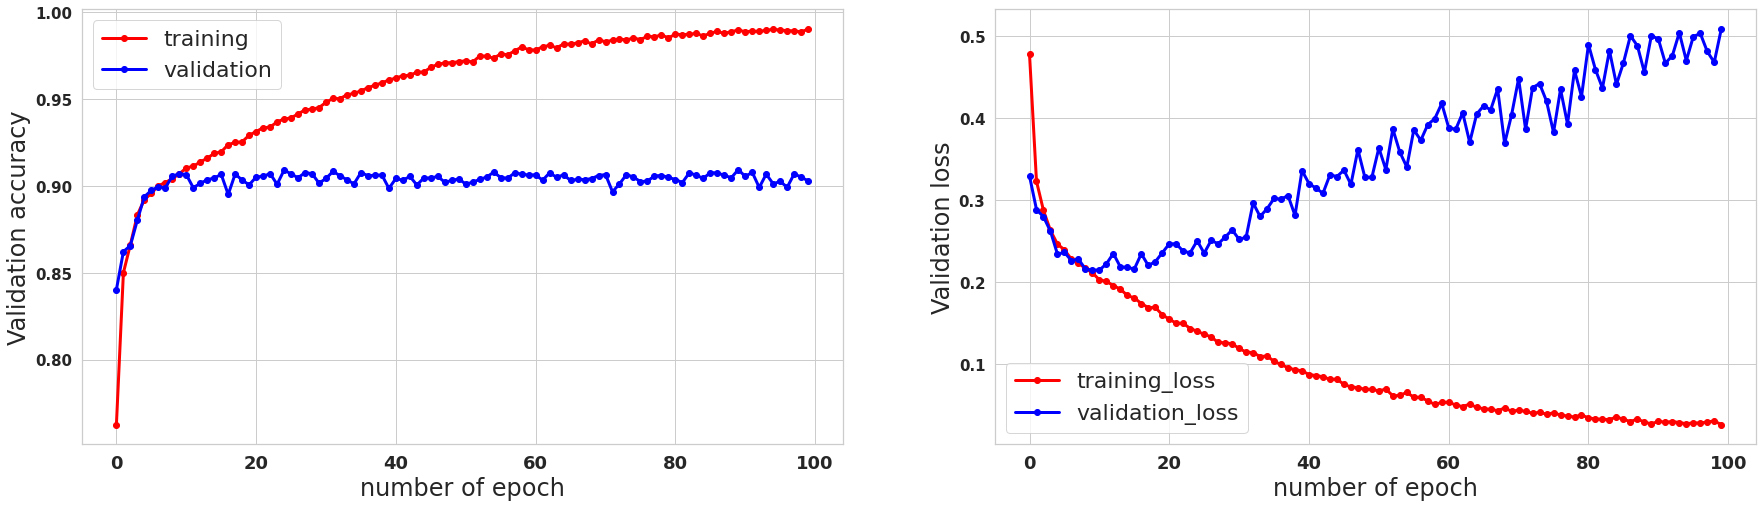

In [ ]:
model_evaluate(LSTM_history)

67/67 [==============================] - 1s 8ms/step - loss: 0.5980 - binary_accuracy: 0.8934
loss 0.5980063676834106
Accuracy 0.8933926820755005
Precision 0.8813980305018911
Recall 0.8986417937789496
f1 score 0.8899363894664051


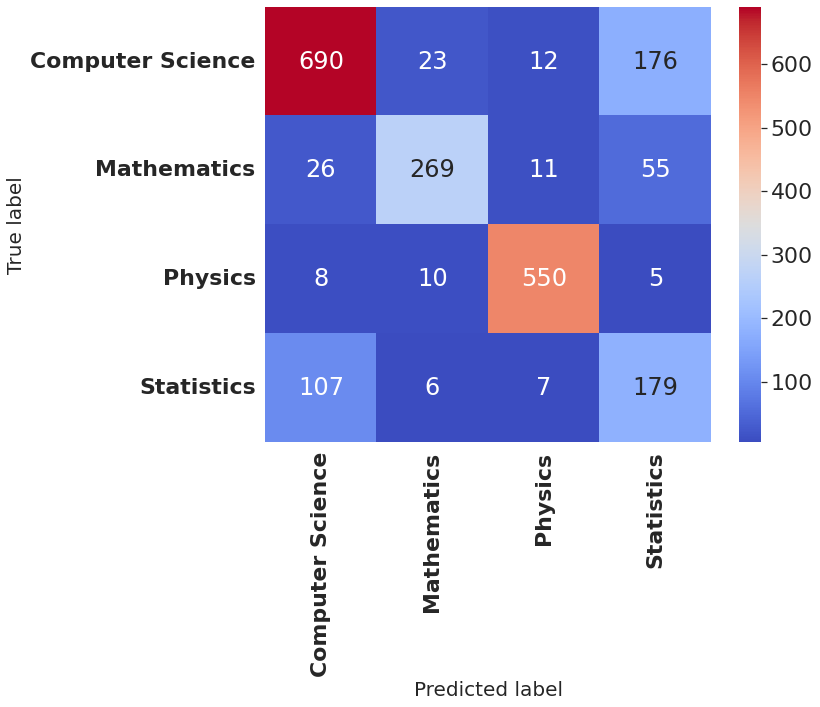

In [ ]:
#make predictions
model = load_model("models/LSTM.h5")
predictions = model.predict(test_padded)
testing_label_seq_numpy = y_test.to_numpy()
evaluation = model.evaluate(test_padded,y_test)
weighted_averaged_recall = average_precision_score(testing_label_seq_numpy, predictions, average='micro')
weighted_averaged_precision = average_precision_score(testing_label_seq_numpy, predictions,  average='macro')
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(weighted_averaged_precision))
print('Recall {}'.format(weighted_averaged_recall))
print('f1 score {}'.format(2*((weighted_averaged_recall*weighted_averaged_precision)/(weighted_averaged_recall+weighted_averaged_precision))))

conf_matrix(predictions)

In [ ]:
GRU_model, GRU_history =directional_classifier_model(model_name = GRU,
                                                            file_name = 'GRU.h5',
                                                            GRU_unit = 128,
                                                            epochs = 100,
                                                            batch = 256)


----------------------------- sequential_classifier_model -----------------------------
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 300)          22191300  
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 200, 300)         0         
 lDropout1D)                                                     
                                                                 
 gru_2 (GRU)                 (None, 200, 128)          165120    
                                                                 
 dense_25 (Dense)            (None, 200, 28)           3612      
                                                                 
 dropout_20 (Dropout)        (None, 200, 28)           0         
                                                                 
 dense_26 (Dense)            (No

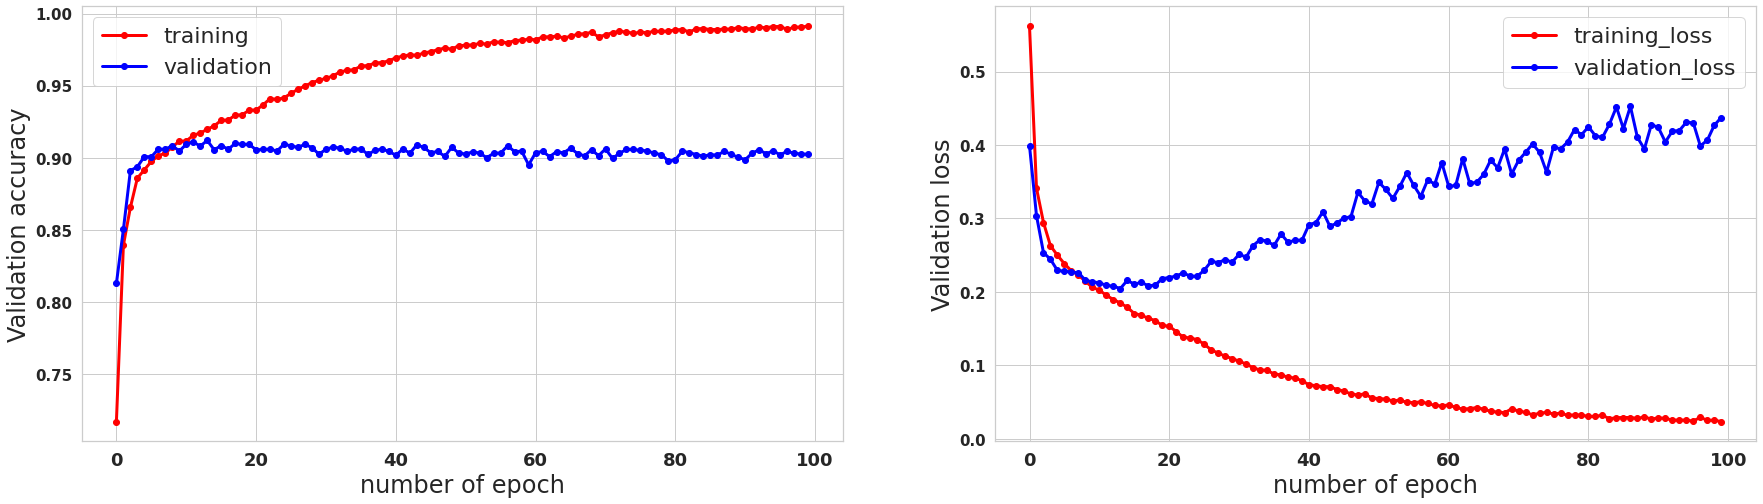

In [ ]:
model_evaluate(GRU_history)

67/67 [==============================] - 1s 7ms/step - loss: 0.2255 - binary_accuracy: 0.9057
loss 0.22545646131038666
Accuracy 0.905693531036377
Precision 0.8987299904320085
Recall 0.9197103215261623
f1 score 0.9090991252556887


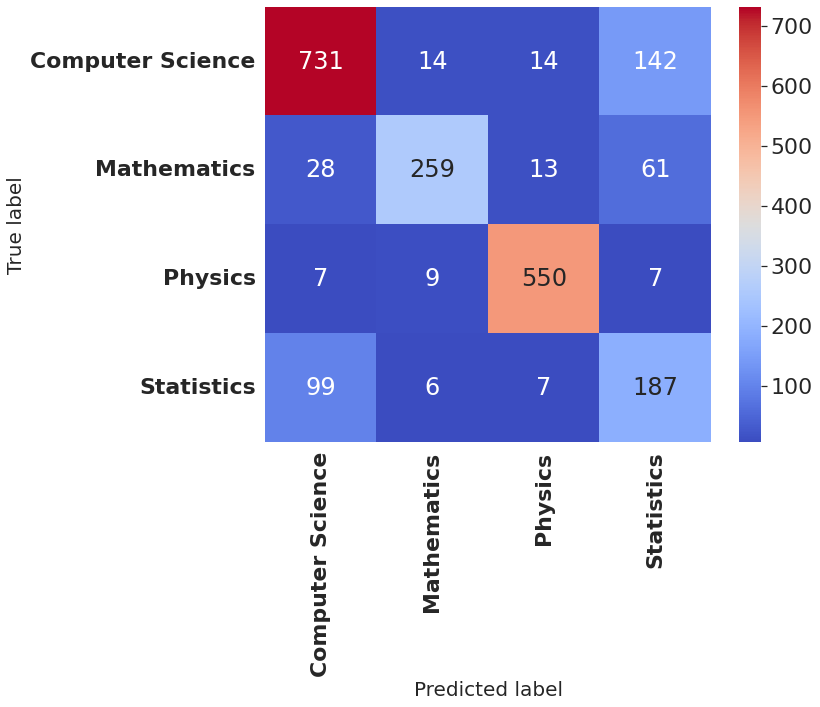

In [ ]:
#make predictions
model = load_model("models/GRU.h5")
predictions = model.predict(test_padded)
testing_label_seq_numpy = y_test.to_numpy()
evaluation = model.evaluate(test_padded,y_test)
weighted_averaged_recall = average_precision_score(testing_label_seq_numpy, predictions, average='micro')
weighted_averaged_precision = average_precision_score(testing_label_seq_numpy, predictions,  average='macro')
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(weighted_averaged_precision))
print('Recall {}'.format(weighted_averaged_recall))
print('f1 score {}'.format(2*((weighted_averaged_recall*weighted_averaged_precision)/(weighted_averaged_recall+weighted_averaged_precision))))

conf_matrix(predictions)

**DIrectional Hybrid Model**

**CNN-LSTM**

In [ ]:
def directional_hybrid_classifier_model(model_name,file_name,GRU_unit, epochs, batch, p_optimizer:str = 'adam' , 
                                   p_loss:str = 'binary_crossentropy', p_metrics:list = ['binary_accuracy']):
    """
    Build a directional Models for classification
    """
    filepath = 'models/'+file_name
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.5, patience=2, 
                                    verbose=1, mode='auto', 
                                    min_delta=0.001, cooldown=1, min_lr=0.00001)
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_binary_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='auto')
    
    callback_list = [acc_callback, checkpoint]
    
    print('----------------------------- Hybrid_sequential_classifier_model -----------------------------')
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(73971, embedding_dim, input_length=train_padded.shape[1],weights=[embedding_matrix],trainable =False),
        tf.keras.layers.SpatialDropout1D(0.7),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
        
        tf.keras.layers.MaxPooling1D(pool_size=2),
        model_name(GRU_unit,return_sequences=True),
        tf.keras.layers.Dense(28, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_category, activation='sigmoid')
])
    model.compile(optimizer=p_optimizer, loss = p_loss, metrics = p_metrics)
    model.summary()
    model_history = model.fit(train_padded, y_train, 
                    epochs=epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, y_valid), 
                    verbose=1,
                    callbacks = callback_list)
    return model,model_history

----------------------------- Hybrid_sequential_classifier_model -----------------------------
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 200, 300)          22191300  
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 200, 300)         0         
 lDropout1D)                                                     
                                                                 
 conv1d (Conv1D)             (None, 200, 32)           28832     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 100, 32)          0         
 )                                                               
                                                                 
 lstm_3 (LSTM)               (None, 100, 128)          82432     
                         

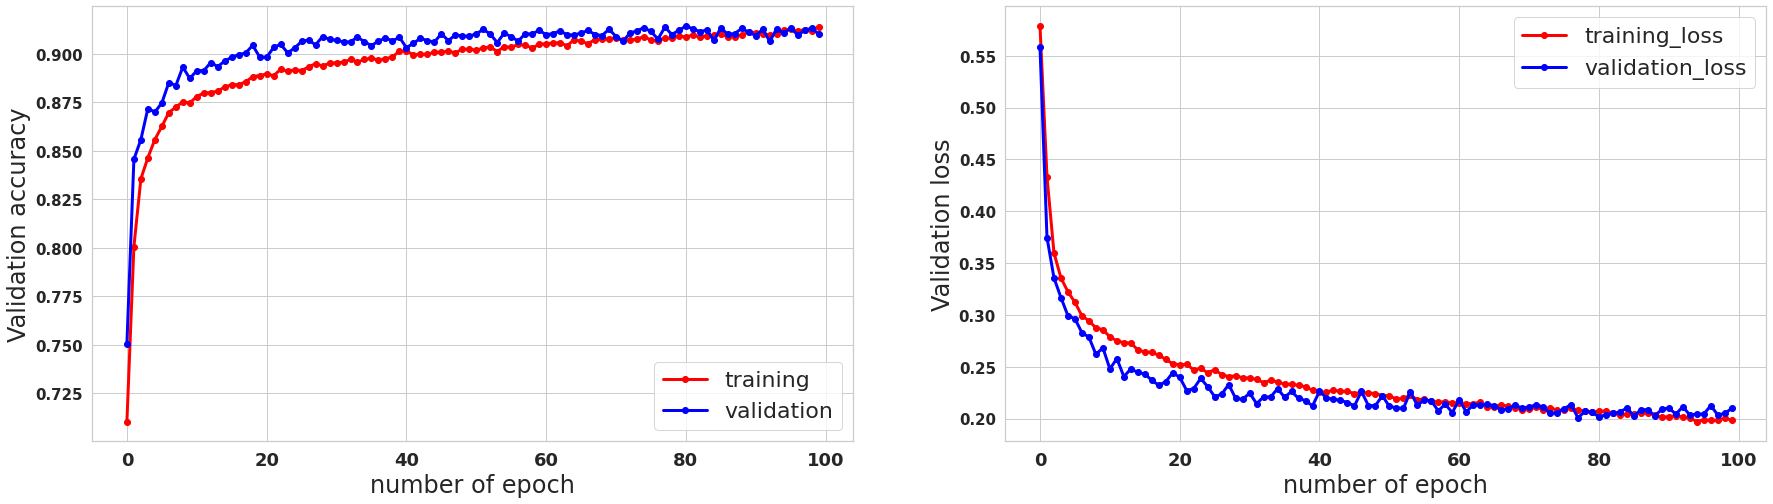

In [ ]:
CLSTM_model, CLSTM_history =directional_hybrid_classifier_model(model_name = LSTM,
                                                            file_name = 'CLSTM.h5',
                                                            GRU_unit =128,
                                                            epochs = 100,
                                                            batch = 256)
model_evaluate(CLSTM_history)

67/67 [==============================] - 1s 6ms/step - loss: 0.2231 - binary_accuracy: 0.9045
loss 0.22310857474803925
Accuracy 0.9045220017433167
Precision 0.8970716413610766
Recall 0.9194846979854003
f1 score 0.9081399011548434


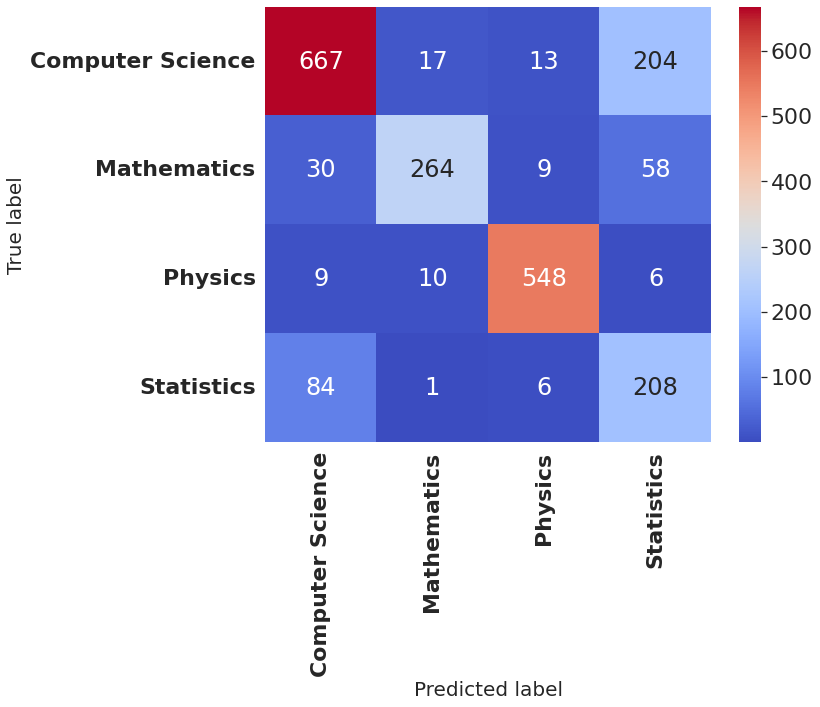

In [ ]:
#make predictions
model = load_model("models/CLSTM.h5")
predictions = model.predict(test_padded)
testing_label_seq_numpy = y_test.to_numpy()
evaluation = model.evaluate(test_padded,y_test)
weighted_averaged_recall = average_precision_score(testing_label_seq_numpy, predictions, average='micro')
weighted_averaged_precision = average_precision_score(testing_label_seq_numpy, predictions,  average='macro')
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(weighted_averaged_precision))
print('Recall {}'.format(weighted_averaged_recall))
print('f1 score {}'.format(2*((weighted_averaged_recall*weighted_averaged_precision)/(weighted_averaged_recall+weighted_averaged_precision))))

conf_matrix(predictions)

**CNN-GRU**

In [ ]:
CGRU_model, CGRU_history =directional_hybrid_classifier_model(model_name = GRU,
                                                            file_name = 'CGRU.h5',
                                                            GRU_unit =128,
                                                            epochs = 100,
                                                            batch = 256)


----------------------------- Hybrid_sequential_classifier_model -----------------------------
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 200, 300)          22191300  
                                                                 
 spatial_dropout1d_7 (Spatia  (None, 200, 300)         0         
 lDropout1D)                                                     
                                                                 
 conv1d_1 (Conv1D)           (None, 200, 32)           28832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 32)          0         
 1D)                                                             
                                                                 
 gru_3 (GRU)                 (None, 100, 128)          62208     
                         

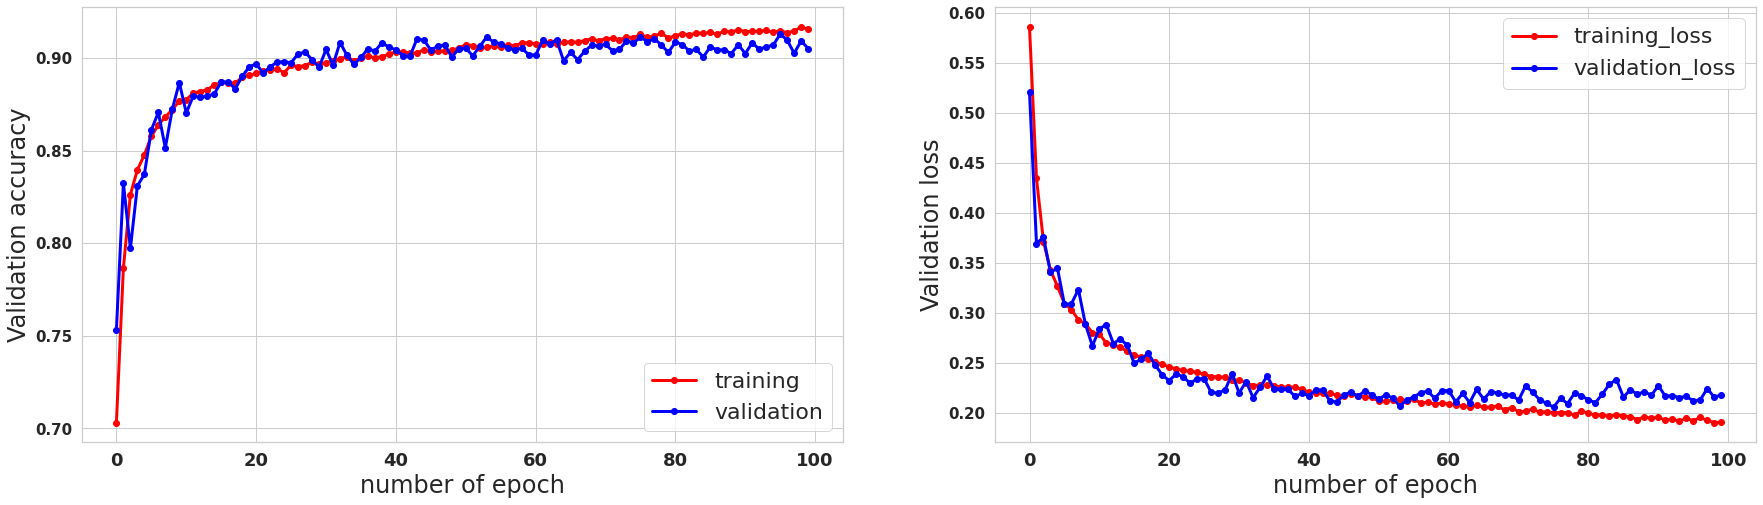

In [ ]:
model_evaluate(CGRU_history)

67/67 [==============================] - 1s 7ms/step - loss: 0.2247 - binary_accuracy: 0.9021
loss 0.22465646266937256
Accuracy 0.9020618796348572
Precision 0.8967236964057009
Recall 0.9165948472714994
f1 score 0.9065503933853057


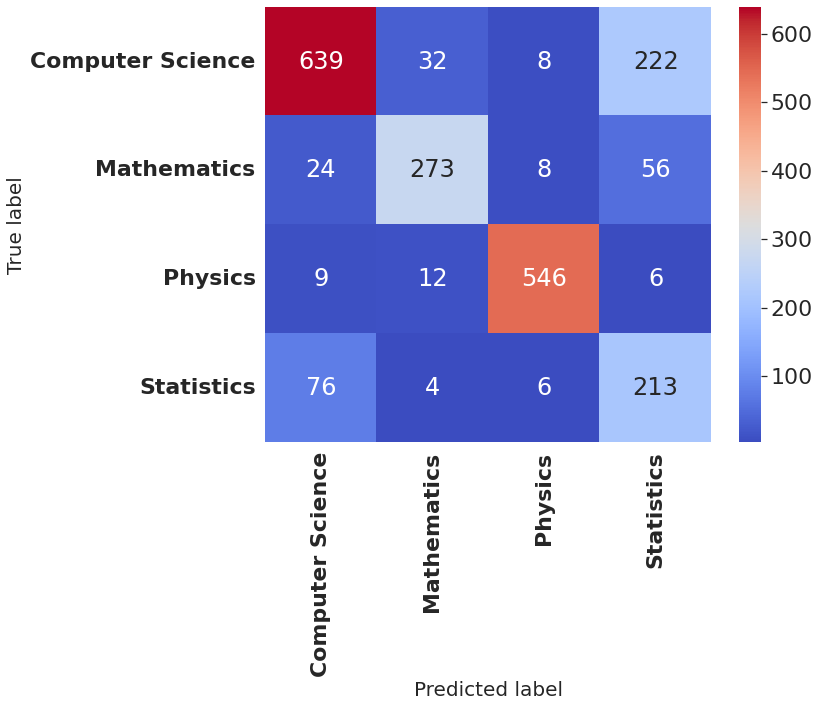

In [ ]:
#make predictions


model = load_model("models/CGRU.h5")
predictions = model.predict(test_padded)
testing_label_seq_numpy = y_test.to_numpy()
evaluation = model.evaluate(test_padded,y_test)
weighted_averaged_recall = average_precision_score(testing_label_seq_numpy, predictions, average='micro')
weighted_averaged_precision = average_precision_score(testing_label_seq_numpy, predictions,  average='macro')
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(weighted_averaged_precision))
print('Recall {}'.format(weighted_averaged_recall))
print('f1 score {}'.format(2*((weighted_averaged_recall*weighted_averaged_precision)/(weighted_averaged_recall+weighted_averaged_precision))))

conf_matrix(predictions)

**Bi-directional Hybrid Model**

In [ ]:
def bidirectional_hybrid_classifier_model(model_name,file_name,GRU_unit, epochs, batch, p_optimizer:str = 'adam' , 
                                   p_loss:str = 'binary_crossentropy', p_metrics:list = ['binary_accuracy']):
    """
    Build a directional Models for classification
    """
    filepath = 'models/'+file_name
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.5, patience=2, 
                                    verbose=1, mode='auto', 
                                    min_delta=0.001, cooldown=1, min_lr=0.00001)
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_binary_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='auto')
    
    callback_list = [acc_callback, checkpoint]
    
    print('----------------------------- Biderectional Hybrid_sequential_classifier_model -----------------------------')
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(73971, embedding_dim, input_length=train_padded.shape[1],weights=[embedding_matrix],trainable =False),
        tf.keras.layers.SpatialDropout1D(0.7),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
        
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Bidirectional(model_name(GRU_unit,return_sequences=True)),
        tf.keras.layers.Dense(28, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_category, activation='sigmoid')
])
    model.compile(optimizer=p_optimizer, loss = p_loss, metrics = p_metrics)
    model.summary()
    model_history = model.fit(train_padded, y_train, 
                    epochs=epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, y_valid), 
                    verbose=1,
                    callbacks = callback_list)
    return model,model_history

**CNN-BiLSTM**

----------------------------- Biderectional Hybrid_sequential_classifier_model -----------------------------
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 200, 300)          22191300  
                                                                 
 spatial_dropout1d_8 (Spatia  (None, 200, 300)         0         
 lDropout1D)                                                     
                                                                 
 conv1d_2 (Conv1D)           (None, 200, 32)           28832     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 100, 32)          0         
 1D)                                                             
                                                                 
 bidirectional_4 (Bidirectio  (None, 100, 400)         372800    
 nal)      

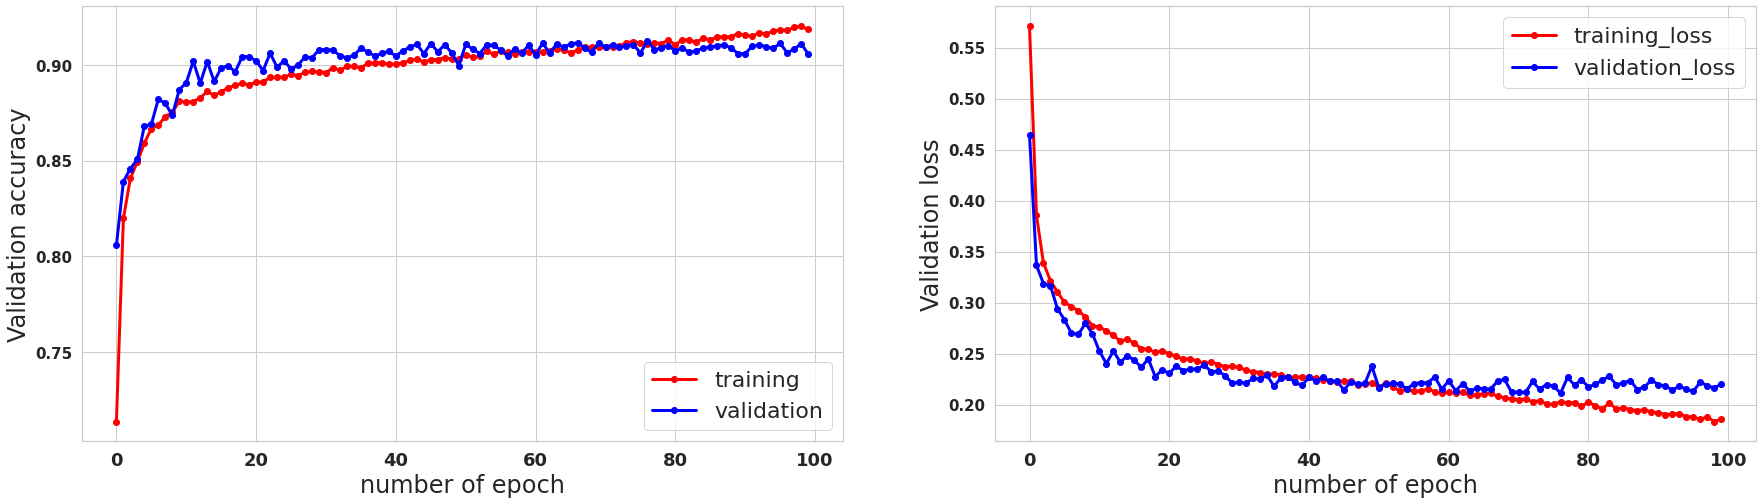

In [ ]:
CBILSTM_model, CBILSTM_history =bidirectional_hybrid_classifier_model(model_name = LSTM,
                                                            file_name = 'CBILSTM.h5',
                                                            GRU_unit =200,
                                                            epochs = 100,
                                                            batch = 256)
model_evaluate(CBILSTM_history)

67/67 [==============================] - 1s 9ms/step - loss: 0.2233 - binary_accuracy: 0.9043
loss 0.2232758104801178
Accuracy 0.9042876958847046
Precision 0.8954449904937414
Recall 0.9181278105543057
f1 score 0.9066445506006009


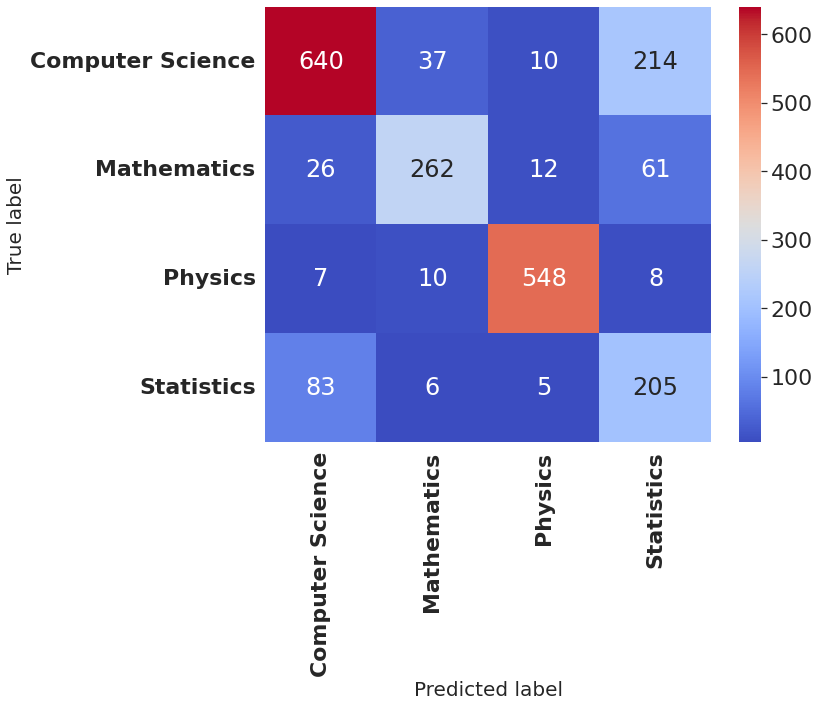

In [ ]:
#make predictions


model = load_model("models/CBILSTM.h5")
predictions = model.predict(test_padded)
testing_label_seq_numpy = y_test.to_numpy()
evaluation = model.evaluate(test_padded,y_test)
weighted_averaged_recall = average_precision_score(testing_label_seq_numpy, predictions, average='micro')
weighted_averaged_precision = average_precision_score(testing_label_seq_numpy, predictions,  average='macro')
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(weighted_averaged_precision))
print('Recall {}'.format(weighted_averaged_recall))
print('f1 score {}'.format(2*((weighted_averaged_recall*weighted_averaged_precision)/(weighted_averaged_recall+weighted_averaged_precision))))

conf_matrix(predictions)

**CNN-BiGRU**

In [ ]:
CBIGRU_model, CBIGRU_history =bidirectional_hybrid_classifier_model(model_name = GRU,
                                                            file_name = 'CBIGRU.h5',
                                                            GRU_unit =200,
                                                            epochs = 100,
                                                            batch = 128)


----------------------------- Biderectional Hybrid_sequential_classifier_model -----------------------------
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 200, 300)          22191300  
                                                                 
 spatial_dropout1d_9 (Spatia  (None, 200, 300)         0         
 lDropout1D)                                                     
                                                                 
 conv1d_3 (Conv1D)           (None, 200, 32)           28832     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 100, 32)          0         
 1D)                                                             
                                                                 
 bidirectional_5 (Bidirectio  (None, 100, 400)         280800    
 nal)      

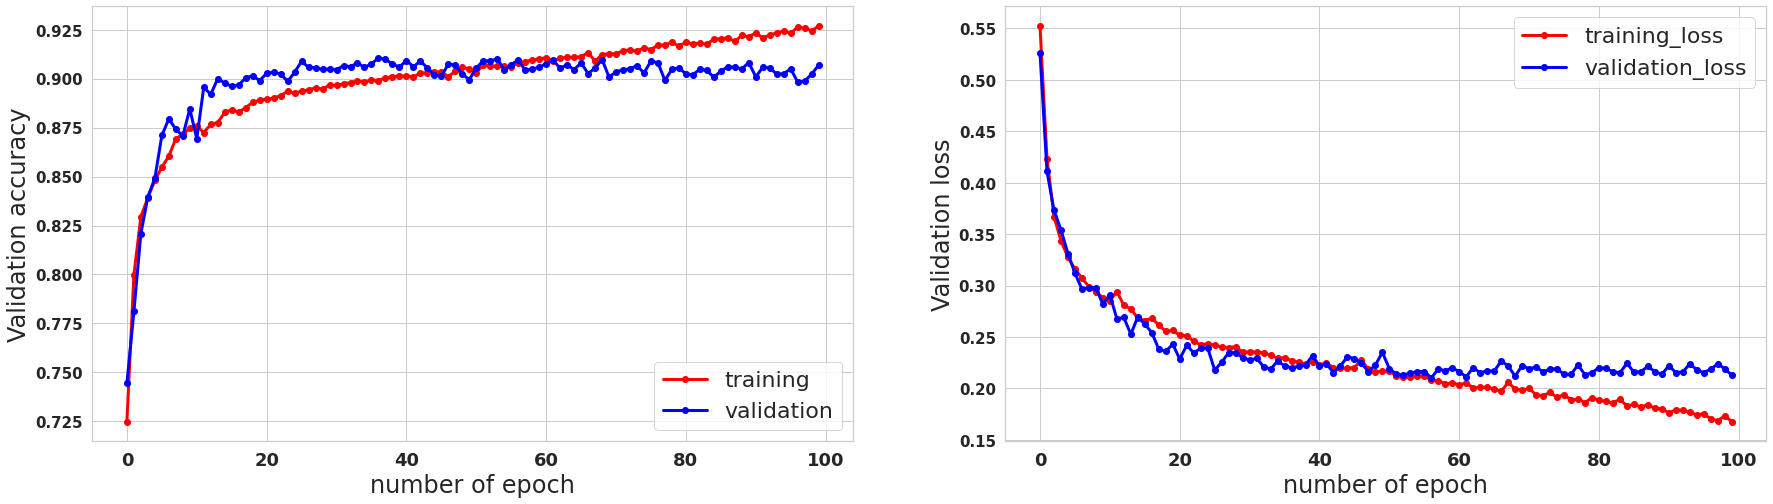

In [ ]:
model_evaluate(CBIGRU_history)

67/67 [==============================] - 1s 9ms/step - loss: 0.2385 - binary_accuracy: 0.9007
loss 0.23845329880714417
Accuracy 0.9006560444831848
Precision 0.8922446712837787
Recall 0.9135604172631233
f1 score 0.9027767386066219


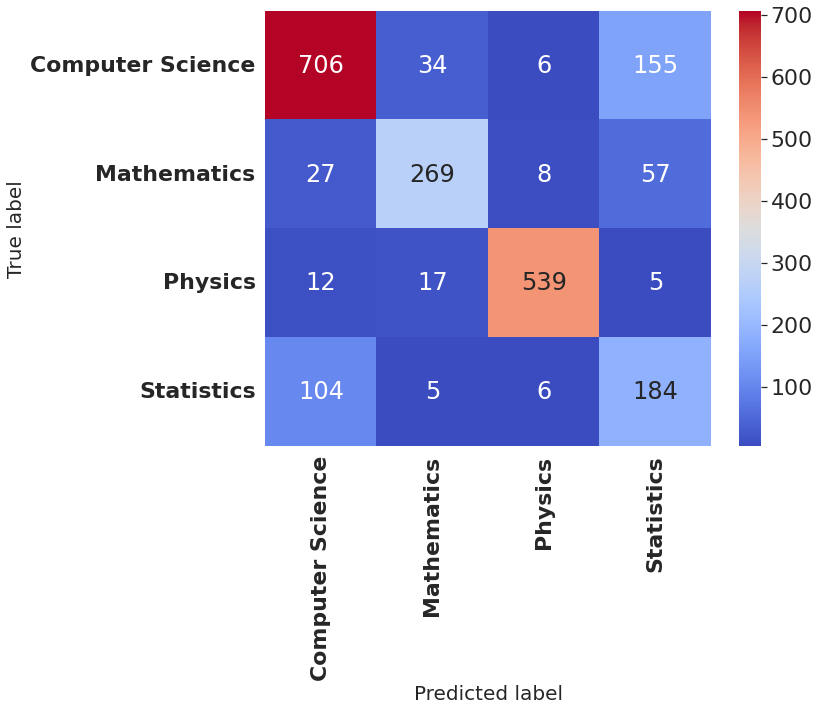

In [ ]:
#make predictions


model = load_model("models/CBIGRU.h5")
predictions = model.predict(test_padded)
testing_label_seq_numpy = y_test.to_numpy()
evaluation = model.evaluate(test_padded,y_test)
weighted_averaged_recall = average_precision_score(testing_label_seq_numpy, predictions, average='micro')
weighted_averaged_precision = average_precision_score(testing_label_seq_numpy, predictions,  average='macro')
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(weighted_averaged_precision))
print('Recall {}'.format(weighted_averaged_recall))
print('f1 score {}'.format(2*((weighted_averaged_recall*weighted_averaged_precision)/(weighted_averaged_recall+weighted_averaged_precision))))

conf_matrix(predictions)

In [ ]:
# Plot all model results
def model_all_evaluate(history1,history2,history3,history4):
  sns.set_style("whitegrid")
  H1 = history1.history
  H2 = history2.history
  H3 = history3.history
  H4 = history4.history
  fig = plt.figure(figsize = (20, 8))
  plt.subplot(121)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation accuracy")
  plt.plot(H1['val_binary_accuracy'], label = 'BiGRU', marker='o', color='red', linewidth=3)
  plt.plot(H2['val_binary_accuracy'], label = 'BiLSTM', marker='o', color='blue', linewidth=3)
  plt.plot(H3['val_binary_accuracy'], label = 'LSTM', marker='o', color='yellow', linewidth=3)
  plt.plot(H4['val_binary_accuracy'], label = 'GRU', marker='o', color='green', linewidth=3)
  plt.xticks( rotation=0, weight = 'bold')
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend(prop={'size': 20})

  plt.subplot(122)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation loss")
  plt.plot(H1['val_loss'], label = 'BiGRU', marker='o', color='red', linewidth=3)
  plt.plot(H2['val_loss'], label = 'BiLSTM', marker='o', color='blue', linewidth=3)
  plt.plot(H3['val_loss'], label = 'LSTM', marker='o', color='yellow', linewidth=3)
  plt.plot(H4['val_loss'], label = 'GRU', marker='o', color='green', linewidth=3)
  plt.xticks( rotation=0, weight = 'bold')
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend(prop={'size': 20})


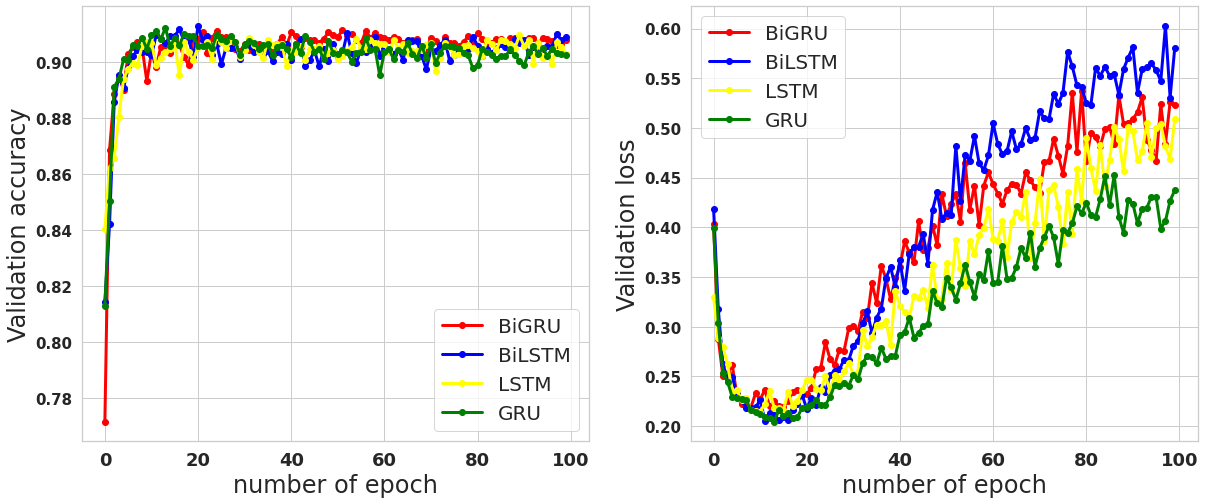

In [ ]:
model_all_evaluate(BiGRU_history, BiLSTM_history,LSTM_history, GRU_history )

In [ ]:
# Plot all model results
def model_all_evaluate(history1,history2,history3,history4):
  sns.set_style("whitegrid")
  H1 = history1.history
  H2 = history2.history
  H3 = history3.history
  H4 = history4.history
  fig = plt.figure(figsize = (20, 8))
  plt.subplot(121)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation accuracy")
  plt.plot(H1['val_binary_accuracy'], label = 'CNN-BiGRU', marker='o', color='red', linewidth=3)
  plt.plot(H2['val_binary_accuracy'], label = 'CNN-BiLSTM', marker='o', color='blue', linewidth=3)
  plt.plot(H3['val_binary_accuracy'], label = 'CNN-LSTM', marker='o', color='yellow', linewidth=3)
  plt.plot(H4['val_binary_accuracy'], label = 'CNN-GRU', marker='o', color='green', linewidth=3)
  plt.xticks( rotation=0, weight = 'bold')
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend(prop={'size': 20})

  plt.subplot(122)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation loss")
  plt.plot(H1['val_loss'], label = 'CNN-BiGRU', marker='o', color='red', linewidth=3)
  plt.plot(H2['val_loss'], label = 'CNN-BiLSTM', marker='o', color='blue', linewidth=3)
  plt.plot(H3['val_loss'], label = 'CNN-LSTM', marker='o', color='yellow', linewidth=3)
  plt.plot(H4['val_loss'], label = 'CNN-GRU', marker='o', color='green', linewidth=3)
  plt.xticks( rotation=0, weight = 'bold')
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend(prop={'size': 20})


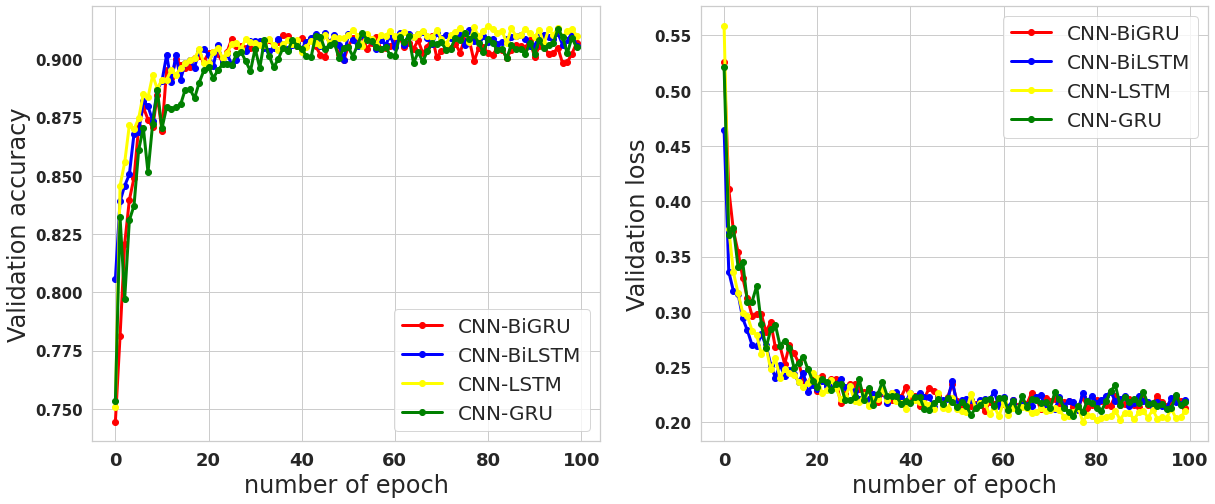

In [ ]:
model_all_evaluate(CBIGRU_history, CBILSTM_history,CLSTM_history, CGRU_history )

In [ ]:
CBigru = load_model("models/CBIGRU.h5")
CBilstm = load_model("models/CBILSTM.h5")
Clstm = load_model("models/CLSTM.h5")
Cgru = load_model("models/CGRU.h5")
MLA = {
     'CNN-BiRU' : CBigru,
     'CNN-BiLSTM' : CBilstm,
     'CNN-LSTM' : Clstm,
     'CNN-GRU' : Cgru, 
}
columns = []
hybrid_compare = pd.DataFrame(columns = columns)
# n_classes=4
row_index = 0
for name,alg in MLA.items():
    MLA_name = name
    evaluation = alg.evaluate(test_padded,y_test)
    y_pred = alg.predict(test_padded)
    weighted_averaged_recall = average_precision_score(testing_label_seq_numpy, y_pred, average='micro')
    weighted_averaged_precision = average_precision_score(testing_label_seq_numpy, y_pred,  average='macro')

    weighted_averaged_f1 = 2*((weighted_averaged_recall*weighted_averaged_precision)/(weighted_averaged_recall+weighted_averaged_precision))
    hybrid_compare.loc[row_index,'Name'] = MLA_name
    hybrid_compare.loc[row_index, 'Accuracy'] = evaluation[1]
    hybrid_compare.loc[row_index, 'loss'] = evaluation[0]
    hybrid_compare.loc[row_index, 'Precision'] = weighted_averaged_precision
    hybrid_compare.loc[row_index, 'Recall'] = weighted_averaged_recall
    hybrid_compare.loc[row_index, 'F1 Score'] = weighted_averaged_f1
   

    row_index+=1
    
hybrid_compare.sort_values(by = ['Accuracy'], ascending = False, inplace = True)    
hybrid_compare

67/67 [==============================] - 1s 7ms/step - loss: 0.2247 - binary_accuracy: 0.9021


,Name,Accuracy,loss,Precision,Recall,F1 Score
2,CNN-LSTM,0.904522,0.223109,0.897072,0.919485,0.908140
1,CNN-BiLSTM,0.904288,0.223276,0.895445,0.918128,0.906645
3,CNN-GRU,0.902062,0.224656,0.896724,0.916595,0.906550
0,CNN-BiRU,0.900656,0.238453,0.892245,0.913560,0.902777


In [ ]:
Bigru = load_model("models/BiGRU.h5")
Bilstm = load_model("models/BiLSTM.h5")
lstm = load_model("models/LSTM.h5")
gru = load_model("models/GRU.h5")
MLA = {
     'Bidirectional GRU' : Bigru,
     'Bidirectional LSTM' : Bilstm,
     'LSTM' : lstm,
     'GRU' : gru, 
}

columns = []
compare = pd.DataFrame(columns = columns)
# n_classes=4
row_index = 0
for name,alg in MLA.items():
    MLA_name = name
    evaluation = alg.evaluate(test_padded,y_test)
    y_pred = alg.predict(test_padded)
    weighted_averaged_recall = average_precision_score(testing_label_seq_numpy, y_pred, average='micro')
    weighted_averaged_precision = average_precision_score(testing_label_seq_numpy, y_pred,  average='macro')

    weighted_averaged_f1 = 2*((weighted_averaged_recall*weighted_averaged_precision)/(weighted_averaged_recall+weighted_averaged_precision))
    compare.loc[row_index,'Name'] = MLA_name
    compare.loc[row_index, 'Accuracy'] = evaluation[1]
    compare.loc[row_index, 'loss'] = evaluation[0]
    compare.loc[row_index, 'Precision'] = weighted_averaged_precision
    compare.loc[row_index, 'Recall'] = weighted_averaged_recall
    compare.loc[row_index, 'F1 Score'] = weighted_averaged_f1
   

    row_index+=1
    
compare.sort_values(by = ['Accuracy'], ascending = False, inplace = True)    
compare

67/67 [==============================] - 1s 7ms/step - loss: 0.2255 - binary_accuracy: 0.9057


,Name,Accuracy,loss,Precision,Recall,F1 Score
3,GRU,0.905694,0.225456,0.898730,0.919710,0.909099
1,Bidirectional LSTM,0.903819,0.238592,0.898164,0.916432,0.907206
0,Bidirectional GRU,0.901007,0.467556,0.890789,0.909572,0.900083
2,LSTM,0.893393,0.598006,0.881398,0.898642,0.889936
